# Results of model-informed precision dosing using PKPD modelling

In [1]:
import os

import chi
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pints
import seaborn as sns
import xarray as xr
sns.set_theme()

from model import (
    define_hamberg_model,
    HambergEliminationRateCovariateModel
)

## Calibration to trial phase I data

Import data

In [2]:
# Import data
directory = os.path.dirname(os.getcwd())
data = pd.read_csv(directory + '/data/trial_phase_I.csv')

# Define model
mechanistic_model, _ = define_hamberg_model(pk_only=True)
population_model = chi.ComposedPopulationModel([
    chi.CovariatePopulationModel(
        chi.LogNormalModel(centered=False),
        HambergEliminationRateCovariateModel()),
    chi.LogNormalModel(centered=False)])

# Import inference results
directory = os.getcwd()
posterior = xr.load_dataset(
    directory + '/posteriors/posterior_trial_phase_I.nc')

Reshape data and compute residuals

In [3]:
# Reshape data
temp = data[data.Observable == 'central_warfarin.warfarin_concentration']
ids = temp.ID.dropna().unique()
times = temp.Time.dropna().unique()
concs = np.empty(shape=(len(ids), len(times)))
for idx, _id in enumerate(ids):
    concs[idx] = temp[temp.ID == _id].Value.values

covariates = np.empty(shape=(len(ids), 2))
covariates[:, 0] = data[data.Observable == 'CYP2C9'].Value.values
covariates[:, 1] = data[data.Observable == 'Age'].Value.values

# Get model fits
pop_parameters = np.vstack([
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior['Log std. myokit.volume'].values.flatten()]).T
indiv_parameters = np.vstack([
    posterior['myokit.elimination_rate'].values,
    posterior['myokit.volume'].values]).T

n_samples = len(pop_parameters)
parameters = np.empty(shape=(n_samples, len(ids), 2))
for idx in range(n_samples):
    parameters[idx] = population_model.compute_individual_parameters(
        parameters=pop_parameters[idx],
        eta=indiv_parameters[:, idx],
        covariates=covariates)

mechanistic_model.set_dosing_regimen(dose=10, start=0)
indiv_fits = np.empty(shape=(n_samples, len(ids), len(times)))
for idx, samples in enumerate(parameters):
    for idd, indiv_params in enumerate(samples):
        indiv_fits[idx, idd] = mechanistic_model.simulate(
            indiv_params, times)[0]

cov_model = HambergEliminationRateCovariateModel()
pop_fits = np.empty(shape=(n_samples, len(ids), len(times)))
for idx, samples in enumerate(pop_parameters):
    for idd, covs in enumerate(covariates):
        log_ke, _ = cov_model.compute_population_parameters(
            parameters=samples[2:5], pop_parameters=samples[:2][:, np.newaxis],
            covariates=covs[np.newaxis, :])[0, :, 0]
        pop_fits[idx, idd] = mechanistic_model.simulate(
            parameters=np.exp([log_ke, samples[5]]), times=times)[0]

Visualise results

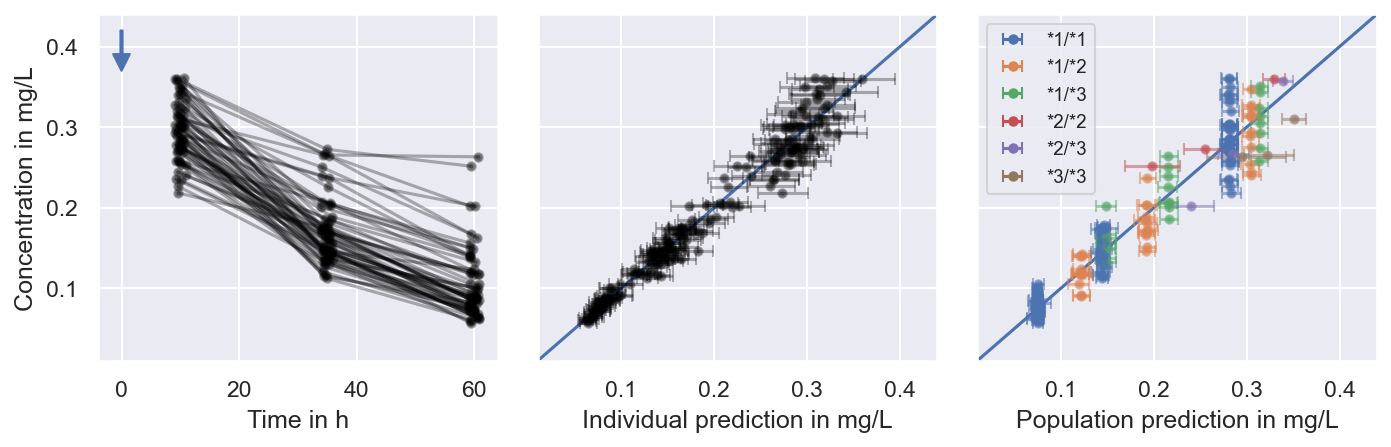

In [6]:
# Create layout
fontsize = 14
my_dpi = 192
fig, axes = plt.subplots(
    nrows=1, ncols=3, figsize=(2250 // my_dpi, 700 // my_dpi), dpi=150,
    sharey=True, gridspec_kw=dict(wspace=0.1))

# Visualise measurements
for c in concs:
    jitter = np.random.uniform(-1, 1, size=len(times))
    axes[0].plot(
        times + jitter, c, marker='o', color='black',
        alpha=0.3, markersize=4)
    axes[0].scatter(
        times + jitter, c, marker='o', color='black',
        alpha=0.3, s=4)

# Visualise dose point
axes[0].annotate(
    "", xy=(0, 0.37), xytext=(0, 0.42),
    arrowprops=dict(width=1, headwidth=8, headlength=8, color=sns.color_palette()[0]))

# Visualise residuals
axes[1].plot(
    [0, 1], [0, 1], transform=axes[1].transAxes, color=sns.color_palette()[0])
medians = np.median(indiv_fits, axis=0)
fifth = medians - np.percentile(indiv_fits, axis=0, q=5)
ninetyfifth = np.percentile(indiv_fits, axis=0, q=95) - medians
for idf, f in enumerate(medians):
    axes[1].errorbar(
        f, concs[idf], marker='o', color='black', alpha=0.3, ls='none',
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[1].scatter(
        f, concs[idf], marker='o', color='black', alpha=0.3, s=4)

axes[2].plot(
    [0, 1], [0, 1], transform=axes[2].transAxes, color=sns.color_palette()[0])
medians = np.median(pop_fits, axis=0)
fifth = medians - np.percentile(pop_fits, axis=0, q=5)
ninetyfifth = np.percentile(pop_fits, axis=0, q=95) - medians
for idf, f in enumerate(medians):
    axes[2].errorbar(
        f, concs[idf], marker='o', alpha=0.5, ls='none',
        color=sns.color_palette()[int(covariates[idf, 0])],
        xerr=np.vstack((fifth[idf:idf+1], ninetyfifth[idf:idf+1])),
        capsize=3, markersize=4)
    axes[2].scatter(
        f, concs[idf], marker='o', alpha=0.5, s=4,
        color=sns.color_palette()[int(covariates[idf, 0])])

# Add legend to population residuals
labels = ['*1/*1', '*1/*2', '*1/*3', '*2/*2', '*2/*3', '*3/*3']
for idl, label in enumerate(labels):
    axes[2].errorbar(
            [0, 0], [10, 11], marker='o', ls='none',
            color=sns.color_palette()[idl], label=label,
            xerr=[[1, 1], [1, 1]], capsize=3, markersize=4)
axes[2].legend(fontsize=int(0.7 * fontsize), loc='upper left')

# Label axes
axes[0].set_xlabel('Time in h')
axes[0].set_ylabel('Concentration in mg/L')
axes[1].set_xlabel('Individual prediction in mg/L')
axes[1].set_ylabel('')
axes[2].set_xlabel('Population prediction in mg/L')
axes[2].set_ylabel('')
axes[0].set_xlim([-4, 64])
axes[1].set_ylim([0.01, 0.44])
axes[1].set_xlim([0.01, 0.44])
axes[2].set_ylim([0.01, 0.44])
axes[2].set_xlim([0.01, 0.44])

plt.savefig('1_trial_phase_1.pdf', bbox_inches='tight')
plt.savefig('1_trial_phase_1.tif', bbox_inches='tight')

plt.show()

Covariate summary

In [7]:
print('Fraction with *1/*1: ', np.sum(covariates[:, 0] == 0) / len(covariates))
print('Fraction with *1/*2: ', np.sum(covariates[:, 0] == 1) / len(covariates))
print('Fraction with *1/*3: ', np.sum(covariates[:, 0] == 2) / len(covariates))
print('Fraction with *2/*2: ', np.sum(covariates[:, 0] == 3) / len(covariates))
print('Fraction with *2/*3: ', np.sum(covariates[:, 0] == 4) / len(covariates))
print('Fraction with *3/*3: ', np.sum(covariates[:, 0] == 5) / len(covariates))
print(
    'Age: %.0f (%.0f - %.0f)' % (
        np.median(covariates[:, 1]),
        np.percentile(covariates[:, 1], q=5),
        np.percentile(covariates[:, 1], q=95)))

Fraction with *1/*1:  0.6166666666666667
Fraction with *1/*2:  0.2
Fraction with *1/*3:  0.13333333333333333
Fraction with *2/*2:  0.016666666666666666
Fraction with *2/*3:  0.016666666666666666
Fraction with *3/*3:  0.016666666666666666
Age: 69 (58 - 79)


Visualise posterior distribution

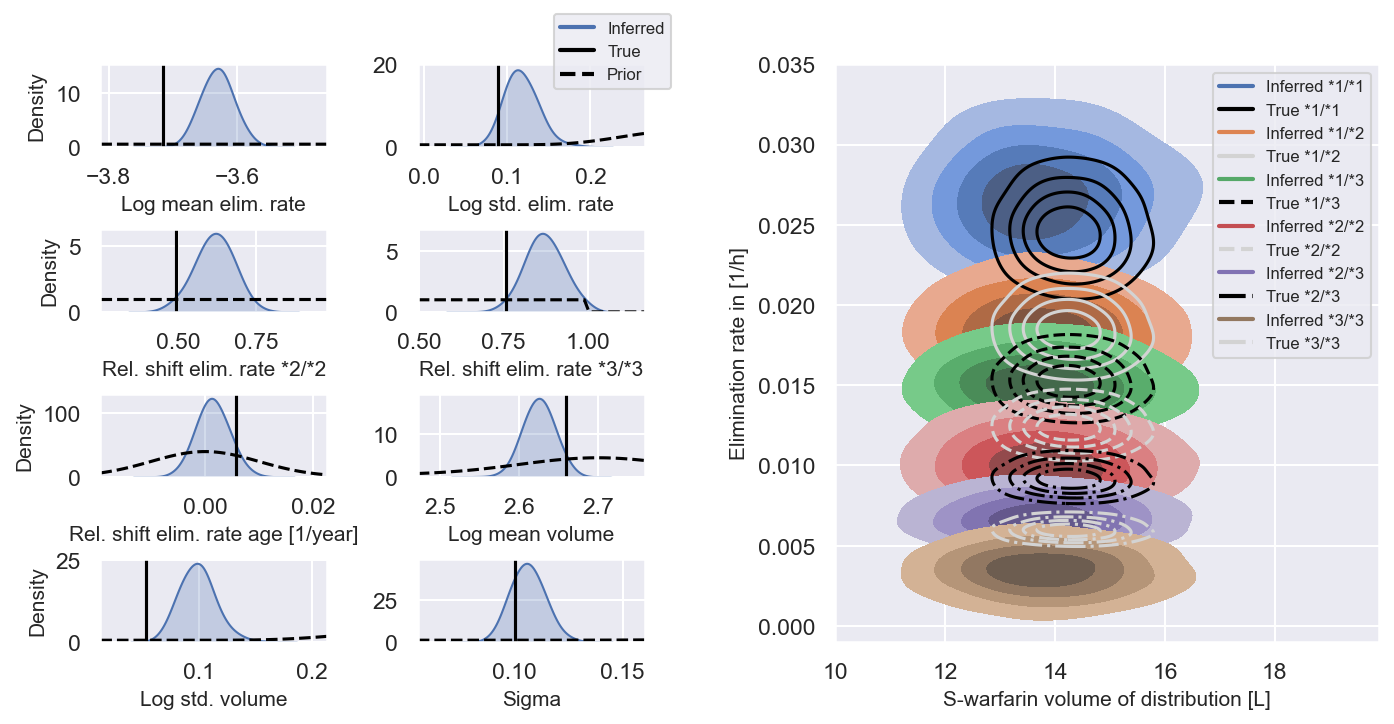

In [14]:
# Create layout
fontsize = 10
my_dpi = 192
fig = plt.figure(figsize=(2250 // my_dpi, 1000 // my_dpi), dpi=150)
outer = gridspec.GridSpec(1, 2, wspace=0.35, width_ratios=[1, 1])

# Create axes for marginal posteriors
axes = []
inner = gridspec.GridSpecFromSubplotSpec(
    4, 2, subplot_spec=outer[0], hspace=1, wspace=0.4)
axes.append(plt.Subplot(fig, inner[0]))
axes.append(plt.Subplot(fig, inner[1]))
axes.append(plt.Subplot(fig, inner[2]))
axes.append(plt.Subplot(fig, inner[3]))
axes.append(plt.Subplot(fig, inner[4]))
axes.append(plt.Subplot(fig, inner[5]))
axes.append(plt.Subplot(fig, inner[6]))
axes.append(plt.Subplot(fig, inner[7]))

# Create axis for IIV parameters
axes.append(plt.Subplot(fig, outer[1]))

# Add axes to figure
for ax in axes:
    fig.add_subplot(ax)

# Plot inference results (parameter space)
seed = np.random.default_rng(3)
n_samples = 5000
pop_parameters = np.vstack([
    posterior['Log mean myokit.elimination_rate'].values.flatten(),
    posterior['Log std. myokit.elimination_rate'].values.flatten(),
    posterior['Rel. elimination rate shift *2*2'].values.flatten(),
    posterior['Rel. elimination rate shift *3*3'].values.flatten(),
    posterior['Rel. elimination rate shift with age'].values.flatten(),
    posterior['Log mean myokit.volume'].values.flatten(),
    posterior['Log std. myokit.volume'].values.flatten(),
    posterior['Pooled Sigma log'].values.flatten()]).T
sns.kdeplot(
    x=pop_parameters[:, 0], fill=True, ax=axes[0], bw_adjust=2)
sns.kdeplot(
    x=pop_parameters[:, 1], fill=True, ax=axes[1], bw_adjust=2)
sns.kdeplot(
    x=pop_parameters[:, 2], fill=True, ax=axes[2], bw_adjust=2)
sns.kdeplot(
    x=pop_parameters[:, 3], fill=True, ax=axes[3], bw_adjust=2)
sns.kdeplot(
    x=pop_parameters[:, 4], fill=True, ax=axes[4], bw_adjust=2)
sns.kdeplot(
    x=pop_parameters[:, 5], fill=True, ax=axes[5], bw_adjust=2)
sns.kdeplot(
    x=pop_parameters[:, 6], fill=True, ax=axes[6], bw_adjust=2)
sns.kdeplot(
    x=pop_parameters[:, 7], fill=True, ax=axes[7], bw_adjust=2)

# Plot priors
log_priors = [
    pints.GaussianLogPrior(-3, 0.1),       # Mean log clearance
    pints.LogNormalLogPrior(-1, 0.3),      # Sigma log clearance
    pints.UniformLogPrior(0, 1),           # Rel. shift clearance CYP29P *2
    pints.UniformLogPrior(0, 1),           # Rel. shift clearance CYP29P *3
    pints.GaussianLogPrior(0, 0.01),       # Rel. shift clearance Age
    pints.GaussianLogPrior(2.7, 0.1),      # Mean log volume
    pints.LogNormalLogPrior(-1, 0.3),      # Sigma log volume
    pints.LogNormalLogPrior(-1, 0.3)       # Sigma log drug conc.
]
for idp, param in enumerate(pop_parameters.T):
    min_value = np.min(param)
    max_value = np.max(param)
    span = max_value - min_value
    min_value -= 0.5 * span
    max_value += 0.5 * span
    xs = np.linspace(min_value, max_value)
    evals = []
    for x in xs:
        evals.append(np.exp(log_priors[idp]([x])))
    if idp in [0, 1, 5, 6]:
        evals = np.array(evals) + 0.5
    if idp == 7:
        evals = np.array(evals) + 1
    axes[idp].plot(xs, evals, color='black', linestyle='--')
    axes[idp].set_xlim([min_value, max_value])

# Plot data-generating distribution as reference to parameter space
true_parameters = [-3.716, 0.089, 0.495, 0.757, 0.00571, 3.353, 0.054, 0.1]
for idx, ax in enumerate(axes[:-1]):
    p = true_parameters[idx]
    if idx == 5:
        p -= np.log(2)
    ax.axvline(x=p, color='black', linestyle='solid')

# Plot inferred population distribution
population_model = chi.ComposedPopulationModel([
    chi.CovariatePopulationModel(
        chi.LogNormalModel(),
        HambergEliminationRateCovariateModel()),
    chi.LogNormalModel(),
    chi.PooledModel()])
parameters = pop_parameters[np.random.choice(
    np.arange(len(pop_parameters)), size=n_samples, replace=True)]

# Define covariates
typical_age = 68
np.random.seed(12)
covariates = np.zeros(shape=(n_samples, 2))
covariates[:, 1] = np.random.lognormal(
    mean=np.log(typical_age), sigma=0.1, size=n_samples)

# Sample subpopulations
styles = ['solid', 'solid', 'dashed', 'dashed', 'dashdot', 'dashdot']
colors = ['black', 'lightgrey', 'black', 'lightgrey', 'black', 'lightgrey']
for idc, cyp in enumerate([0, 1, 2, 3, 4, 5]):
    covariates[:, 0] = cyp
    samples = np.empty(shape=(n_samples, 3))
    for ids, params in enumerate(parameters):
        cov = covariates[ids:ids+1]
        samples[ids, :] = population_model.sample(
            params, seed=seed, covariates=cov)[0]
    sns.kdeplot(
        x=samples[:, 1], y=samples[:, 0], fill=True, bw_adjust=1.5,
        levels=[0.2, 0.4, 0.6, 0.8, 1], ax=axes[-1])

    # Plot data-generating distribution as reference to parameter space
    samples = population_model.sample(
        true_parameters, n_samples, seed=1, covariates=covariates)
    sns.kdeplot(
        x=samples[:, 1] / 2, y=samples[:, 0], fill=False, bw_adjust=1.5,
        color=colors[idc], levels=[0.2, 0.4, 0.6, 0.8, 1],
        ax=axes[-1], linestyles=styles[idc])

# Add legends
axes[1].set_ylim([0, 20])
axes[1].plot(
    [0.1, 0.1], [100, 101], color=sns.color_palette()[0],
    label='Inferred', linewidth=2)
axes[1].plot(
    [0.1, 0.1], [100, 101], color='black',
    label='True', linewidth=2)
axes[1].plot(
    [0.1, 0.1], [100, 101], color='black', linestyle='--',
    label='Prior', linewidth=2)
axes[1].legend(loc=[0.6, 0.7], fontsize=int(0.8 * fontsize))

axes[-1].set_ylim([-0.001, 0.035])
axes[-1].set_xlim([10, 19.9])
labels = ['*1/*1', '*1/*2', '*1/*3', '*2/*2', '*2/*3', '*3/*3']
for idl, label in enumerate(labels):
    axes[-1].plot(
        [0.1, 0.1], [100, 101], color=sns.color_palette()[idl],
        label='Inferred %s' % label, linewidth=2)
    axes[-1].plot(
        [0.1, 0.1], [100, 101], color=colors[idl], linestyle=styles[idl],
        label='True %s' % label, linewidth=2)
axes[-1].legend(fontsize=int(0.8 * fontsize))


# Label axes
axes[0].set_xlabel('Log mean elim. rate', fontsize=fontsize)
axes[0].set_ylabel('Density', fontsize=fontsize)
axes[1].set_xlabel('Log std. elim. rate', fontsize=fontsize)
axes[1].set_ylabel('', fontsize=fontsize)
axes[2].set_xlabel('Rel. shift elim. rate *2/*2', fontsize=fontsize)
axes[2].set_ylabel('Density', fontsize=fontsize)
axes[3].set_xlabel('Rel. shift elim. rate *3/*3', fontsize=fontsize)
axes[3].set_ylabel('', fontsize=fontsize)
axes[4].set_xlabel('Rel. shift elim. rate age [1/year]', fontsize=fontsize)
axes[4].set_ylabel('Density', fontsize=fontsize)
axes[5].set_xlabel('Log mean volume', fontsize=fontsize)
axes[5].set_ylabel('', fontsize=fontsize)
axes[6].set_xlabel('Log std. volume', fontsize=fontsize)
axes[6].set_ylabel('Density', fontsize=fontsize)
axes[7].set_xlabel('Sigma', fontsize=fontsize)
axes[7].set_ylabel('', fontsize=fontsize)
axes[8].set_ylabel('Elimination rate in [1/h]', fontsize=fontsize)
axes[8].set_xlabel('S-warfarin volume of distribution [L]', fontsize=fontsize)

plt.savefig('2_trial_phase_1_parameter_space.pdf', bbox_inches='tight')
plt.savefig('2_trial_phase_1_parameter_space.tif', bbox_inches='tight')

plt.show()

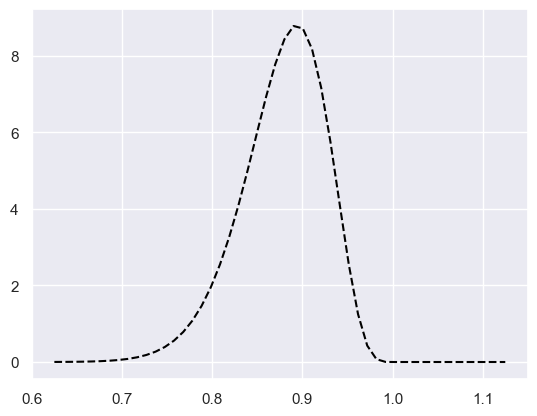

In [208]:
mu = np.mean(pop_parameters[:, 3])
var = np.var(pop_parameters[:, 3])
a = (1 - mu) / var
b = (1 - mu) / mu * a
log_prior = pints.BetaLogPrior(a, b)
min_value = 0.75
max_value = 1
span = max_value - min_value
min_value -= 0.5 * span
max_value += 0.5 * span
xs = np.linspace(min_value, max_value)
evals = []
for x in xs:
    evals.append(np.exp(log_prior([x])))
plt.plot(xs, evals, color='black', linestyle='--')
plt.show()